# 朴素贝叶斯分类器实验
田田 经12计18 2021011048

## 一、朴素贝叶斯分类器设计
### 1、数据提取

In [1]:
import os
import email
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

观察一下邮件头的情况

In [2]:
# 邮件文件夹路径
mail_folder = "./trec06p/data/"

# 存储所有邮件头部信息的集合
headers_set = set()

# 遍历data路径下的所有文件夹
for root, dirs, files in os.walk(mail_folder):
    # 遍历每个文件夹中的所有文件
    for filename in files:
        # 构造文件的完整路径
        file_path = os.path.join(root, filename)
        # 打开文件并解析邮件头部信息
        with open(file_path, 'rb') as file:
            msg = email.message_from_binary_file(file)
            headers_set.update(msg.keys())

In [3]:
len(headers_set)

782

In [4]:
headers_set

{'>From',
 '>Received',
 'Alternate-Recipient',
 'Apparently-To',
 'Approved',
 'Approved-By',
 'Approved-by',
 'At',
 'Authentication-Results',
 'Auto-Submitted',
 'BCC',
 'Batched-Date',
 'Batched-IP',
 'Batched-Sender',
 'Bcc',
 'BestServHost',
 'CBlanchentent-Type',
 'CC',
 'Cc',
 'Cindyubject',
 'Comment',
 'Comments',
 'Content-Class',
 'Content-Description',
 'Content-Disposition',
 'Content-ID',
 'Content-Id',
 'Content-Identifier',
 'Content-Language',
 'Content-Length',
 'Content-Location',
 'Content-MD5',
 'Content-Md5',
 'Content-Return',
 'Content-TVanessae',
 'Content-TranCindyfer-Encoding',
 'Content-Transfer-Encoding',
 'Content-Transfer-encoding',
 'Content-Type',
 'Content-class',
 'Content-description',
 'Content-disposition',
 'Content-language',
 'Content-length',
 'Content-return',
 'Content-transfer-encoding',
 'Content-type',
 'Conversation-Id',
 'Conversion',
 'Country',
 'DATE',
 'Date',
 'Date-Warning',
 'Date-warning',
 'Delivered-To',
 'Delivery-Class',
 'D

观察完毕后，提取这些邮件头进行特征转换
From, Cc, Bcc, Subject, Date, Content-Type, Content-Length, Content-Transfer-Encoding, X-Authenticated, X-Authentication, X-Auth, X-Priority, X-MSMail-Priority

In [5]:
def extract_email_headers(email_path):
    with open(email_path, 'rb') as f:
        msg = email.message_from_binary_file(f)
        headers = {}
        for header in ['From', 'Cc', 'Bcc', 'Subject', 'Date', 'Content-Type', 'Content-Length',
                       'Content-Transfer-Encoding', 'X-Authenticated', 'X-Authentication', 'X-Auth',
                       'X-Priority', 'X-MSMail-Priority']:
            headers[header] = msg.get(header, '<NOT_FOUND>')
        return headers

def extract_email_body(email_path):
    with open(email_path, 'rb') as f:
        msg = email.message_from_binary_file(f)
        body = ""

        if msg.is_multipart():
            for part in msg.walk():
                content_type = part.get_content_type()
                if content_type == 'text/plain' or content_type == 'text/html':
                    payload = part.get_payload(decode=True)
                    body += payload.decode('utf-8', errors='ignore')
        else:
            payload = msg.get_payload(decode=True)
            body = payload.decode('utf-8', errors='ignore')

    return body



文本清洗的函数

In [6]:
def clean_text(text):
    # 去除文本中的 HTML 标签
    text = re.sub(r'<[^>]+>', '', text)
    # 去除文本中的网址链接
    text = re.sub(r'http\S+', 'http', text)
    # 去除文本中的多余空白字符（空格、制表符、换行符等）
    text = re.sub(r'\s+', ' ', text)
    # 去除文本中的数字
    text = re.sub(r'\d+', '', text)
    # 加载英语停用词列表
    stop_words = set(stopwords.words('english'))
    
    # 分词
    words = text.split()

    # 移除停用词
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # 重新组合为文本
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

读取所有的邮件信息

In [7]:
spam_labels = []  # 存储邮件是否是垃圾邮件的列表
file_paths = []   # 存储邮件相对路径的列表

# 打开文件
with open('./trec06p/label/index', 'r') as file:
    # 逐行读取文件内容
    for line in file:
        label, file_path = line.strip().split()
        
        # 将邮件是否是垃圾邮件的标签添加到列表中
        spam_labels.append(label)
        
        # 将邮件相对路径添加到列表中
        file_paths.append(file_path)

In [8]:
file_paths[10]

'../data/000/010'

In [9]:
# 遍历所有邮件文件
headers_list = []
bodies = []
# 遍历文件夹
for email_path in file_paths:
    email_path = './trec06p/' + email_path[2:]
    headers = extract_email_headers(email_path)
    headers_list.append(headers)
    bodies.append(clean_text(extract_email_body(email_path)))

看一下读取的结果对不对

In [10]:
print(len(headers_list), len(bodies))

37822 37822


In [11]:
headers_list[910]

{'From': 'Hans "Unicorn" Van de Looy <amsqnt!hvdl@sequent.com>',
 'Cc': '<NOT_FOUND>',
 'Bcc': '<NOT_FOUND>',
 'Subject': 'Update plan 9 availability',
 'Date': 'Thu, 8 Jun 1995 08:32:13 -0400',
 'Content-Type': '<NOT_FOUND>',
 'Content-Length': '<NOT_FOUND>',
 'Content-Transfer-Encoding': '<NOT_FOUND>',
 'X-Authenticated': '<NOT_FOUND>',
 'X-Authentication': '<NOT_FOUND>',
 'X-Auth': '<NOT_FOUND>',
 'X-Priority': '<NOT_FOUND>',
 'X-MSMail-Priority': '<NOT_FOUND>'}

### 2、特征提取

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
import pickle

In [13]:
headers_list[9]

{'From': '"Austin Sullivan" <rngwmlw@autojobs.nl>',
 'Cc': '<NOT_FOUND>',
 'Bcc': '<NOT_FOUND>',
 'Subject': 'One pill can change all your ideas about sex!',
 'Date': 'Wed, 14 Apr 1993 03:04:59 +0200',
 'Content-Type': 'text/plain;\n\tformat=flowed;\n\tcharset="Windows-1252";\n\treply-type=original',
 'Content-Length': '<NOT_FOUND>',
 'Content-Transfer-Encoding': '7bit',
 'X-Authenticated': '<NOT_FOUND>',
 'X-Authentication': '<NOT_FOUND>',
 'X-Auth': '<NOT_FOUND>',
 'X-Priority': '3',
 'X-MSMail-Priority': 'Normal'}

In [14]:
bodies[9]

'Little magic. Perfect weekends. http'

In [15]:
is_spam_labels = [0 if label == 'ham' else 1 for label in spam_labels]
is_spam_labels[10]

0

用来特征提取的函数，具体操作和思路在报告中有详细讲解。这里只是定义好函数，具体的特征提取操作会在模型训练的时候执行

In [16]:
# 对邮件头进行二值化处理
def binarize_features(email_dict):
    features = ['From', 'Subject', 'Date', 'Content-Type']  # 选择要作为特征的键
    feature_vector = []

    for feature in features:
        if feature in email_dict and email_dict[feature] != '<NOT_FOUND>':
            feature_vector.append(1)
        else:
            feature_vector.append(0)

    return feature_vector

In [17]:
# 把邮件内容转化成特征向量
def getVector(emails, labels, number):
    # 文本预处理和特征提取
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(emails)

    # 使用卡方检验选择特征
    ch2 = SelectKBest(chi2, k=number)
    X_selected = ch2.fit_transform(X, labels)

    # 查看选择的特征词
    selected_feature_names = np.array(vectorizer.get_feature_names_out())[ch2.get_support()]
    return selected_feature_names, X_selected

In [19]:
header_texts = [] # 邮件头的内容
for i in range(len(headers_list)):
    header = headers_list[i]
    header_text = ' '.join(str(value) for value in header.values())
    header_texts.append(clean_text(header_text))

In [20]:
# 存储数据，以便关闭文件后还能直接读取
def saveData(folder_path, name, data):
    # 如果文件夹不存在，则创建文件夹
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    with open(os.path.join(folder_path, f"{name}.pkl"), 'wb') as f:
        pickle.dump(data, f)

In [21]:
saveData("./mydata/", "header_texts", header_texts)
saveData("./mydata/", "bodies", bodies)
saveData("./mydata/", "is_spams", is_spam_labels)

In [22]:
def loadData(folder_path, name):
    file_path = os.path.join(folder_path, f"{name}.pkl")
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        return data
    else:
        print(f"文件 {name}.pkl 不存在.")
        return None

In [23]:
header_texts[100]

'Bob Kummerfeld fans@cse.psu.edu Thu, Jul :: -'

### 3、模型训练

In [24]:
# 现在拥有单词表，特征矩阵和具体的结果
from sklearn.model_selection import KFold
from scipy.sparse import hstack

In [25]:
name1, text1 = getVector(header_texts[:100], is_spam_labels[:100], 100)
name2, text2 = getVector(bodies[:100], is_spam_labels[:100], 200)

In [26]:
a = text1[10]

In [27]:
header_texts = loadData("./mydata/", "header_texts")
bodies = loadData("./mydata/", "bodies")
is_spam_labels = loadData("./mydata/", "is_spams")

In [28]:
len(is_spam_labels)

37822

In [69]:
import numpy as np
from scipy.sparse import csr_matrix

# 实现的多项式朴素贝叶斯分类器
class Multinomial:
    def __init__(self, alpha = 1):
        self.alpha = alpha  # 平滑参数
        self.class_log_prior_ = None  # 每个类的先验概率的对数
        self.feature_log_prob_ = None  # 每个特征给定类的条件概率的对数
        self.classes_ = None  # 类标签的数组

    def fit(self, X, y):
        if isinstance(X, csr_matrix):
            X = X.toarray()
        
        # 计算每个类的邮件数量
        count_sample = X.shape[0]
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        self.class_log_prior_ = np.zeros(n_classes)
        feature_count = np.zeros((n_classes, X.shape[1]))
        
        for i, y_class in enumerate(self.classes_):
            X_c = X[y == y_class]
            self.class_log_prior_[i] = np.log(X_c.shape[0] / count_sample)
            feature_count[i, :] = X_c.sum(axis=0)
        
        # 添加alpha进行拉普拉斯平滑
        self.feature_count_ = feature_count + self.alpha
        self.feature_log_prob_ = np.log(self.feature_count_ / self.feature_count_.sum(axis=1).reshape(-1, 1))
        
    def predict_log_proba(self, X):
        # 计算对数概率
        return X @ self.feature_log_prob_.T + self.class_log_prior_

    def predict(self, X):
        # 预测最可能的类
        log_prob = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_prob, axis=1)]



In [30]:
# 初始化五折交叉验证对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 存储训练的结果
header_names = []
body_names = []
train_preds = []
train_results = []
test_preds = []
test_results = []
models = []
header_number = 21
bodies_number = 40
alpha = 100
# 使用五折交叉验证进行数据分割和模型评估
for train_index, test_index in kf.split(header_texts):
    print("开始一轮")
    # 分割数据
    train_header_texts = [header_texts[i] for i in train_index]
    test_header_texts = [header_texts[i] for i in test_index]
    train_bodies = [bodies[i] for i in train_index]
    test_bodies = [bodies[i] for i in test_index]
    train_is_spam_labels = [is_spam_labels[i] for i in train_index]
    test_is_spam_labels = [is_spam_labels[i] for i in test_index]
    # 从训练集中提取特征
    train_name_headers, train_vector_headers = getVector(train_header_texts, train_is_spam_labels, header_number)
    train_name_bodies, train_vector_bodies = getVector(train_bodies, train_is_spam_labels, bodies_number)
    train_vectors = hstack((train_vector_headers, train_vector_bodies))
    header_names.append(train_name_headers)
    body_names.append(train_name_bodies)
    train_results.append(train_is_spam_labels)
    # 训练这个模型
    model = Multinomial(alpha)
    model.fit(train_vectors, train_is_spam_labels)
    models.append(model)
    train_pred = model.predict(train_vectors)
    train_preds.append(train_pred)
    # 在验证集上提取特征并验证
    test_name_headers, test_vector_headers = getVector(test_header_texts, test_is_spam_labels, header_number)
    test_name_bodies, test_vector_bodies = getVector(test_bodies, test_is_spam_labels, bodies_number)
    test_vectors = hstack((test_vector_headers, test_vector_bodies))
    test_results.append(test_is_spam_labels)
    test_pred = model.predict(test_vectors)
    test_preds.append(test_pred)
    print("结束一轮")

开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮


In [31]:
train_header_texts[10]

'George Job offer person Fri, Apr :: + multipart/alternative; boundary="------------"'

In [32]:
train_bodies[10]

'Job offer person Hello. email brings attention job offer, might interesting you. "Education Partner" russian-based organisation, provides postgraduate education american students/adults leading russian universities academies. searching reliable, honest flexible individual residented United States. High salary (up USD/month), part-time employment, flexible timetable, contract benefits offered. Requirements Male/female years old Resident United States (at least last years) - hours free time within work day informations inquiries job offering, please send contact details vacancy@job-directions.com -Your full name -Your contact email -Your phone number best time reach Thank paying attention. Job Directions Inc., Copyright .'

In [33]:
train_is_spam_labels[10]

1

In [34]:
# 存储训练的结果
saveData("./mydata/", "header_names", header_names)
saveData("./mydata/", "body_names", body_names)
saveData("./mydata/", "train_preds", train_preds)
saveData("./mydata/", "train_results", train_results)
saveData("./mydata/", "test_preds", test_preds)
saveData("./mydata/", "test_results", test_results)
saveData("./mydata/", "models", models)

### 4、性能评估

In [35]:
header_names = loadData("./mydata/", "header_names")
body_names = loadData("./mydata/", "body_names")
train_preds = loadData("./mydata/", "train_preds")
train_results = loadData("./mydata/", "train_results")
test_preds = loadData("./mydata/", "test_preds")
test_results = loadData("./mydata/", "test_results")
models = loadData("./mydata/", "models")

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score, cohen_kappa_score

实现评估性能的函数

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

def evaluate_model(models, test_results, test_preds):
    # 初始化存储所有fold结果的列表
    all_fold_results = []

    # 对每个fold计算指标并存储结果
    for i in range(len(models)):
        fold_results = {}
        fold_results['Accuracy'] = accuracy_score(test_results[i], test_preds[i])
        fold_results['Precision'] = precision_score(test_results[i], test_preds[i])
        fold_results['Recall'] = recall_score(test_results[i], test_preds[i])
        fold_results['F1 Score'] = f1_score(test_results[i], test_preds[i])
        fold_results['Confusion Matrix'] = confusion_matrix(test_results[i], test_preds[i])
        fold_results['ROC AUC'] = roc_auc_score(test_results[i], test_preds[i])
        fold_results['PR AUC'] = average_precision_score(test_results[i], test_preds[i])
        fold_results['Kappa'] = cohen_kappa_score(test_results[i], test_preds[i])
        all_fold_results.append(fold_results)

    # 计算所有fold的平均值
    avg_results = {}
    for metric in all_fold_results[0].keys():
        avg_results[metric] = sum(fold_results[metric] for fold_results in all_fold_results) / len(all_fold_results)

    # 打印每个fold的指标结果
    # for i, fold_results in enumerate(all_fold_results):
    #     print(f"Fold {i+1} Results:")
    #     for metric, value in fold_results.items():
    #         print(f"{metric}: {value}")
    #     print()

    # 打印所有fold的平均指标结果
    print("Average Results Across Folds:")
    for metric, value in avg_results.items():
        if metric == 'Confusion Matrix':
            print(f"{metric}: {value}")
            # 使用热图展示混淆矩阵
            plt.figure(figsize=(8, 6))
            sns.heatmap(value, annot=True, fmt=".2f", cmap="Blues")
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix')
            plt.show()
        # elif metric == 'ROC AUC':
        #     print(f"{metric}: {value}")
        #     # 使用ROC曲线展示
        #     fpr, tpr, _ = roc_curve(test_results[i], test_preds[i])
        #     plt.plot(fpr, tpr, label='ROC Curve')
        #     plt.xlabel('False Positive Rate')
        #     plt.ylabel('True Positive Rate')
        #     plt.title('ROC Curve')
        #     plt.legend()
        #     plt.show()
        elif metric == 'PR AUC':
            print(f"{metric}: {value}")
            # 使用PR曲线展示
            precision, recall, _ = precision_recall_curve(test_results[i], test_preds[i])
            plt.plot(recall, precision, label='PR Curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend()
            plt.show()
        else:
            # 其他指标暂时不展示图形，只打印数值
            print(f"{metric}: {value}")


In [38]:
np.sum(is_spam_labels)

24912

Average Results Across Folds:
Accuracy: 0.8128862252510676
Precision: 0.8847843024476056
Recall: 0.8246021971270021
F1 Score: 0.8528578291416139
Confusion Matrix: [[2040.8  541.2]
 [ 874.2 4108.2]]


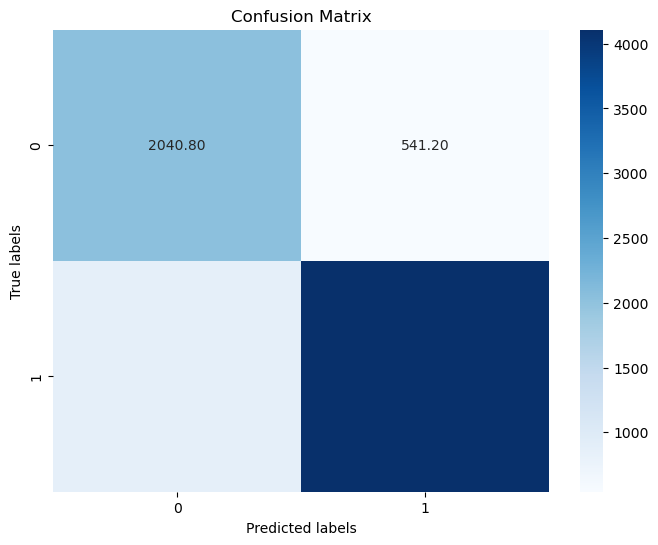

ROC AUC: 0.8076789181553311
PR AUC: 0.8447226602901001


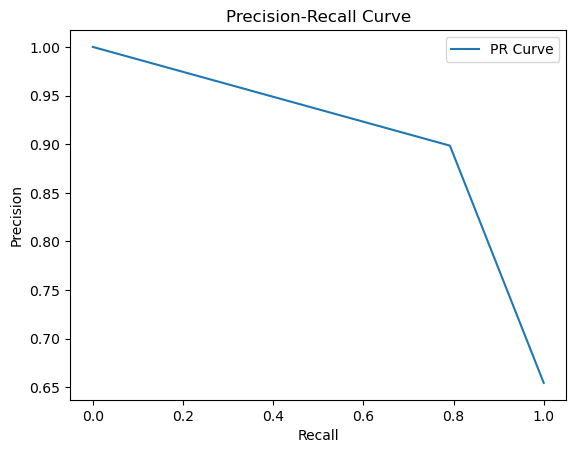

Kappa: 0.5964508105780891


In [39]:
evaluate_model(models, test_results, test_preds)

In [40]:
header_names

[array(['_dragon', 'alternative', 'ascii', 'boundary', 'charset', 'dmdx',
        'edt', 'est', 'flowed', 'format', 'forster', 'handyboard', 'html',
        'iso', 'jonathan', 'jp', 'multipart', 'normal', 'paper', 'plain',
        'text'], dtype=object),
 array(['_dragon', 'alternative', 'ascii', 'boundary', 'charset', 'dmdx',
        'edt', 'est', 'flowed', 'format', 'forster', 'handyboard', 'html',
        'iso', 'jonathan', 'jp', 'multipart', 'normal', 'paper', 'plain',
        'text'], dtype=object),
 array(['_dragon', 'alternative', 'ascii', 'boundary', 'charset', 'dmdx',
        'edt', 'est', 'flowed', 'format', 'forster', 'handyboard', 'html',
        'iso', 'jonathan', 'jp', 'multipart', 'normal', 'paper', 'plain',
        'text'], dtype=object),
 array(['_dragon', 'alternative', 'ascii', 'boundary', 'charset', 'dmdx',
        'edt', 'est', 'flowed', 'format', 'forster', 'handyboard', 'html',
        'iso', 'jonathan', 'jp', 'multipart', 'normal', 'paper', 'plain',
        'tex

In [41]:
body_names

[array(['arizona', 'ascii', 'com', 'content', 'crust', 'data', 'date',
        'dec', 'dmdx', 'edu', 'esmtp', 'file', 'gt', 'id', 'kb', 'list',
        'lt', 'mail', 'message', 'nil', 'owner', 'padding', 'problem',
        'psy', 'psych', 'px', 'received', 'reply', 'send', 'sender',
        'subject', 'thanks', 'type', 'ucsb', 'university', 'use', 'using',
        'version', 'vulnerable', 'wrote'], dtype=object),
 array(['arizona', 'ascii', 'board', 'com', 'crust', 'date', 'dec', 'dmdx',
        'edu', 'esmtp', 'file', 'files', 'gt', 'id', 'kb', 'list', 'lt',
        'mail', 'message', 'nil', 'owner', 'padding', 'problem', 'psy',
        'psych', 'px', 'received', 'reply', 'rpcss', 'send', 'subject',
        'thanks', 'ucsb', 'university', 'use', 'using', 'version',
        'vulnerable', 'wed', 'wrote'], dtype=object),
 array(['arizona', 'ascii', 'com', 'crust', 'data', 'date', 'dec', 'dmdx',
        'edu', 'esmtp', 'file', 'gt', 'id', 'kb', 'list', 'lt', 'mail',
        'message', 'ni

Average Results Across Folds:
Accuracy: 0.8707960456577603
Precision: 0.8865135432371514
Recall: 0.9228333795923216
F1 Score: 0.9040559474615408
Confusion Matrix: [[ 7956.6  2371.4]
 [ 1538.  18391.6]]


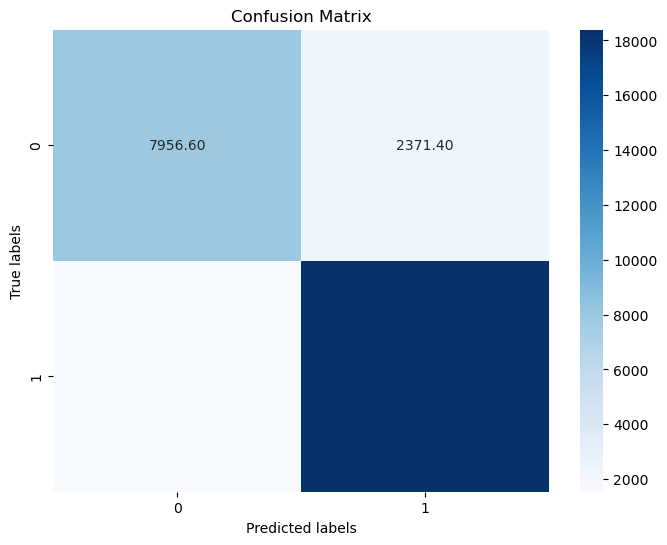

ROC AUC: 0.8466409026944983
PR AUC: 0.8687676913653041


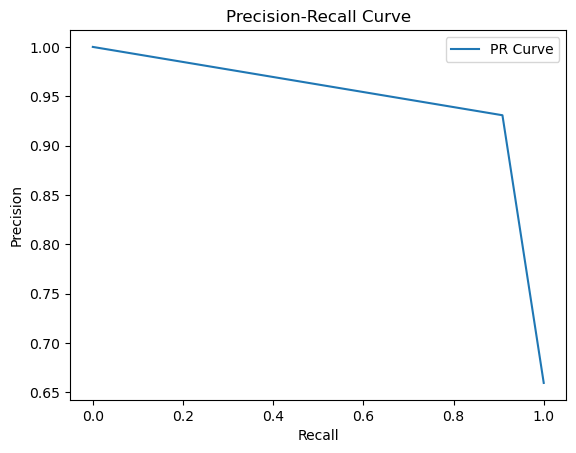

Kappa: 0.7064671225518705


In [42]:
evaluate_model(models, train_results, train_preds)

### 5、结果分析

具体研究一下特征词和是否是垃圾邮件的关系，可视化

In [43]:
# 读取相关的邮件信息
header_texts = loadData("./mydata/", "header_texts")
bodies = loadData("./mydata/", "bodies")
is_spam_labels = loadData("./mydata/", "is_spams")

In [44]:
def calculate_spam_ratio(A, B, specified_string):
    # 创建两个空列表，用于存储包含指定字符串和不包含指定字符串的元素
    contains_string = []
    not_contains_string = []
    
    # 遍历列表A和对应的标签列表B
    for i in range(len(A)):
        if specified_string in A[i]:
            contains_string.append(B[i])  # 如果包含指定字符串，将对应的标签加入contains_string列表
        else:
            not_contains_string.append(B[i])  # 如果不包含指定字符串，将对应的标签加入not_contains_string列表
            
    # 计算两个列表中垃圾邮件的占比
    spam_ratio_contains = sum(contains_string) / len(contains_string) if contains_string else 0
    spam_ratio_not_contains = sum(not_contains_string) / len(not_contains_string) if not_contains_string else 0
    
    # 报告
    return spam_ratio_contains, spam_ratio_not_contains

In [45]:
import matplotlib.pyplot as plt

def plot_spam_probabilities(words, spam_probabilities, non_spam_probabilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(spam_probabilities, non_spam_probabilities, color='blue', alpha=0.5)
    
    for i, word in enumerate(words):
        x = spam_probabilities[i]
        y = non_spam_probabilities[i]
        plt.annotate(word, (x, y), fontsize=8, ha='left', va='bottom', xytext=(5, -5),
                     textcoords='offset points', arrowprops=dict(arrowstyle='-', connectionstyle='arc3'))

    # 添加y=x线的数据点
    max_prob = max(max(spam_probabilities), max(non_spam_probabilities))
    plt.plot([0, max_prob], [0, max_prob], color='red', linestyle='--', label='y=x')
    
    plt.xlabel('Spam Probability')
    plt.ylabel('Ham Probability')
    plt.title('Spam Probability vs Ham Probability for Each Word')
    plt.grid(True)
    plt.legend()  # 添加图例
    plt.show()

In [46]:
header_names = ['_dragon', 'alternative', 'ascii', 'boundary', 'charset', 'dmdx', 'edt', 'est', 'flowed', 'format', 'forster', 'handyboard', 'html', 'iso', 'jonathan', 'jp', 'multipart', 'normal', 'paper', 'plain', 'text']
body_names = ['arizona', 'ascii', 'board', 'code', 'com', 'content', 'crust', 'data', 'date', 'dec', 'digest', 'dmdx', 'edu', 'esmtp', 'file', 'files', 'gt', 'id', 'kb', 'know', 'list', 'lt', 'mail', 'message', 'network', 'nil', 'owner', 'padding', 'pnfs', 'price', 'problem', 'product_table', 'psy', 'psych', 'px', 'received', 'reply', 'rpcss', 'send', 'sender', 'set', 'subject', 'telecom', 'thanks', 'thu', 'type', 'ucsb', 'university', 'use', 'using', 've', 'version', 'vulnerable', 'wed', 'wrote']

In [47]:
spam_ratios = []
ham_ratios = []
for name in header_names:
    spam_ratio, ham_ratio = calculate_spam_ratio(header_texts, is_spam_labels, name)
    spam_ratios.append(spam_ratio)
    ham_ratios.append(ham_ratio)

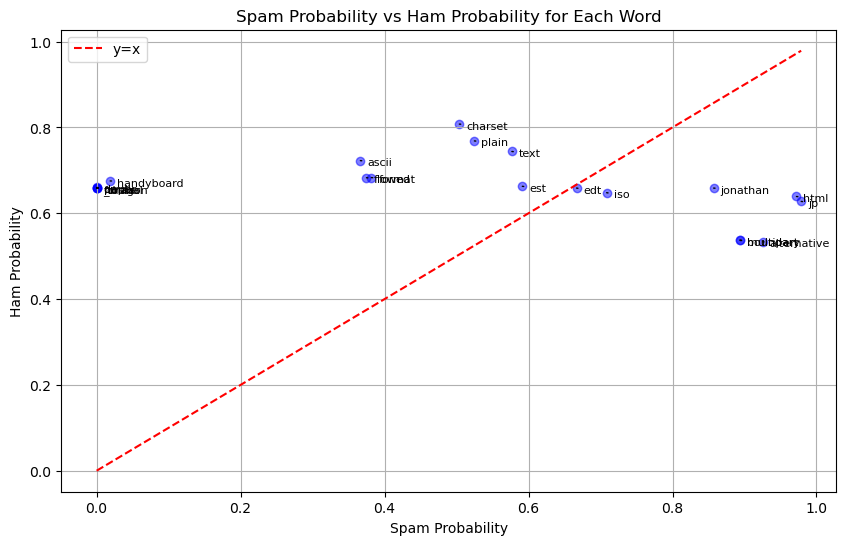

In [48]:
plot_spam_probabilities(header_names, spam_ratios, ham_ratios)

In [49]:
spam_ratios = []
ham_ratios = []
for name in body_names:
    spam_ratio, ham_ratio = calculate_spam_ratio(bodies, is_spam_labels, name)
    spam_ratios.append(spam_ratio)
    ham_ratios.append(ham_ratio)

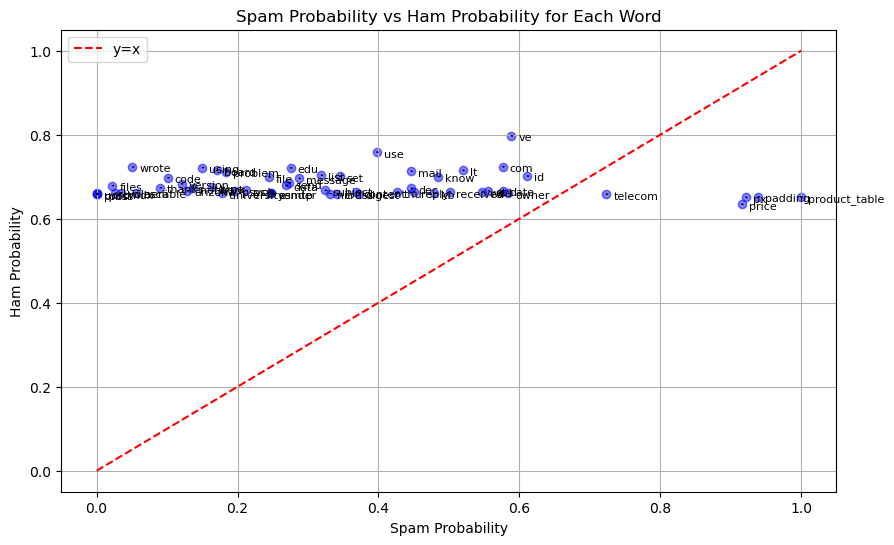

In [50]:
plot_spam_probabilities(body_names, spam_ratios, ham_ratios)

尝试修改模型的算法，具体操作思路在报告这一部分中有详细解释

In [51]:
# 读取相关的邮件信息
header_texts = loadData("./mydata/", "header_texts")
bodies = loadData("./mydata/", "bodies")
is_spam_labels = loadData("./mydata/", "is_spams")

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
# 根据我找出来的新的特征词提取特征向量
def getVectorWithFeatures(emails, feature_words):
    vectorizer = CountVectorizer(stop_words='english', vocabulary=feature_words)
    X = vectorizer.fit_transform(emails)
    return X

In [71]:
# 把特征词按照离y=x的距离排序
def select_distance(words, spam_probabilities, non_spam_probabilities):
    distances = [(words[i], abs(spam_probabilities[i] - non_spam_probabilities[i])) for i in range(len(words))]
    distances.sort(key=lambda x: x[1])  # 按照距离升序排序
    sorted_words = [item[0] for item in distances] 
    return sorted_words, distances

In [54]:
# 具体进行训练
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 存储训练的结果
header_names = []
body_names = []
train_preds = []
train_results = []
test_preds = []
test_results = []
models = []
header_number = 21
bodies_number = 40
# 使用五折交叉验证进行数据分割和模型评估
for train_index, test_index in kf.split(header_texts):
    print("开始一轮")
    # 分割数据
    train_header_texts = [header_texts[i] for i in train_index]
    test_header_texts = [header_texts[i] for i in test_index]
    train_bodies = [bodies[i] for i in train_index]
    test_bodies = [bodies[i] for i in test_index]
    train_is_spam_labels = [is_spam_labels[i] for i in train_index]
    test_is_spam_labels = [is_spam_labels[i] for i in test_index]
    # 从训练集中提取特征
    train_name_headers, train_vector_headers = getVector(train_header_texts, train_is_spam_labels, header_number)
    train_name_bodies, train_vector_bodies = getVector(train_bodies, train_is_spam_labels, bodies_number)
    train_results.append(train_is_spam_labels)
    # 使用计算距离的方式重新提取特征
    spam_ratios = []
    ham_ratios = []
    for name in train_name_headers:
        spam_ratio, ham_ratio = calculate_spam_ratio(train_header_texts, train_is_spam_labels, name)
        spam_ratios.append(spam_ratio)
        ham_ratios.append(ham_ratio)
    sorted_head_names, _ = select_distance(train_name_headers, spam_ratios, ham_ratios)
    train_vector_headers = getVectorWithFeatures(train_header_texts, sorted_head_names[int(len(sorted_head_names)/2.5):-5])

    spam_ratios = []
    ham_ratios = []
    for name in train_name_bodies:
        spam_ratio, ham_ratio = calculate_spam_ratio(train_bodies, train_is_spam_labels, name)
        spam_ratios.append(spam_ratio)
        ham_ratios.append(ham_ratio)
    sorted_body_names, _ = select_distance(train_name_bodies, spam_ratios, ham_ratios)
    train_vector_bodies = getVectorWithFeatures(train_bodies, sorted_body_names[int(len(sorted_body_names)/2.5):-5])
    train_vectors = hstack((train_vector_headers, train_vector_bodies))
    # 训练这个模型
    model = Multinomial(200)
    model.fit(train_vectors, train_is_spam_labels)
    models.append(model)
    train_pred = model.predict(train_vectors)
    train_preds.append(train_pred)
    # 在验证集上提取特征并验证
    test_name_headers, test_vector_headers = getVector(test_header_texts, test_is_spam_labels, header_number)
    test_name_bodies, test_vector_bodies = getVector(test_bodies, test_is_spam_labels, bodies_number)

    # 使用计算距离的方式重新提取特征
    spam_ratios = []
    ham_ratios = []
    for name in test_name_headers:
        spam_ratio, ham_ratio = calculate_spam_ratio(test_header_texts, test_is_spam_labels, name)
        spam_ratios.append(spam_ratio)
        ham_ratios.append(ham_ratio)
    sorted_head_names, _ = select_distance(test_name_headers, spam_ratios, ham_ratios)
    test_vector_headers = getVectorWithFeatures(test_header_texts, sorted_head_names[int(len(sorted_head_names)/2.5):-5])

    spam_ratios = []
    ham_ratios = []
    for name in test_name_bodies:
        spam_ratio, ham_ratio = calculate_spam_ratio(test_bodies, test_is_spam_labels, name)
        spam_ratios.append(spam_ratio)
        ham_ratios.append(ham_ratio)
    sorted_body_names, _ = select_distance(test_name_bodies, spam_ratios, ham_ratios)
    test_vector_bodies = getVectorWithFeatures(test_bodies, sorted_body_names[int(len(sorted_body_names)/2.5):-5])
    test_vectors = hstack((test_vector_headers, test_vector_bodies))

    test_vectors = hstack((test_vector_headers, test_vector_bodies))
    test_results.append(test_is_spam_labels)
    test_pred = model.predict(test_vectors)
    test_preds.append(test_pred)
    print("结束一轮")

开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮


Average Results Across Folds:
Accuracy: 0.8203151848443404
Precision: 0.8402756670287943
Recall: 0.9030886197768643
F1 Score: 0.8691945956286083
Confusion Matrix: [[1706.6  875.4]
 [ 483.8 4498.6]]


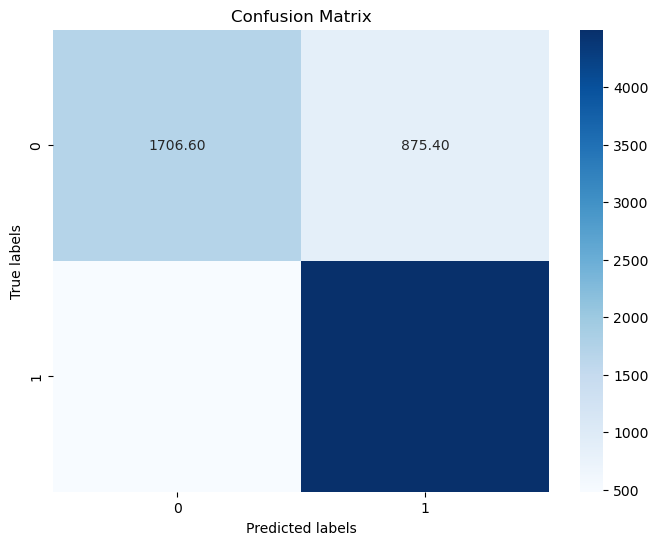

ROC AUC: 0.7826603100814433
PR AUC: 0.8218345848391617


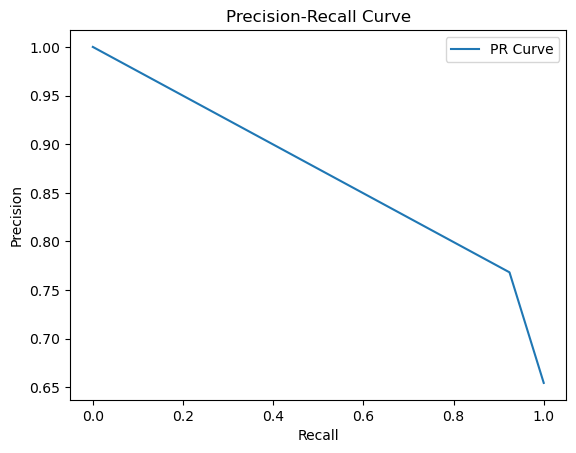

Kappa: 0.58324161732327


In [55]:
evaluate_model(models, test_results, test_preds)

Average Results Across Folds:
Accuracy: 0.8722040190510818
Precision: 0.8869928956409684
Recall: 0.9251082007778306
F1 Score: 0.9051749129971794
Confusion Matrix: [[ 7953.6  2374.4]
 [ 1492.4 18437.2]]


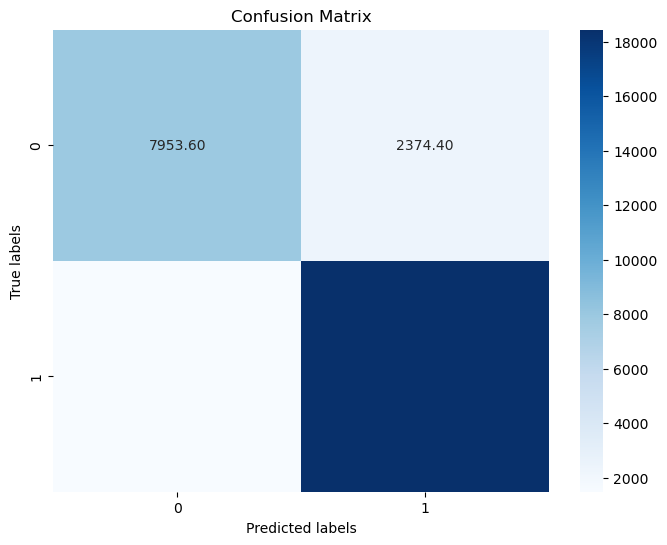

ROC AUC: 0.8475815771610071
PR AUC: 0.8694683929720346


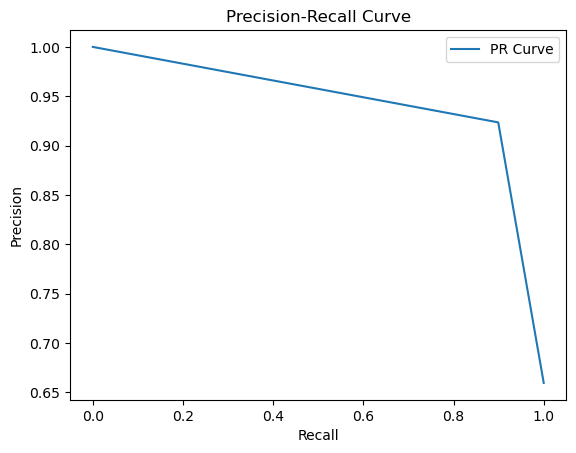

Kappa: 0.7092187583230622


In [56]:
evaluate_model(models, train_results, train_preds)

## 二、针对问题一修改

### 1、采用5%的训练集数据进行训练

In [57]:
header_texts = loadData("./mydata/", "header_texts")
bodies = loadData("./mydata/", "bodies")
is_spam_labels = loadData("./mydata/", "is_spams")
length1 = int(len(header_texts) / 20)
header_texts = header_texts[:length1]
bodies = bodies[:length1]
is_spam_labels = is_spam_labels[:length1]

In [58]:
# 初始化五折交叉验证对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 存储训练的结果
header_names = []
body_names = []
train_preds = []
train_results = []
test_preds = []
test_results = []
models = []
header_number = 10
bodies_number = 40
# 使用五折交叉验证进行数据分割和模型评估
for train_index, test_index in kf.split(header_texts):
    print("开始一轮")
    # 分割数据
    train_header_texts = [header_texts[i] for i in train_index]
    test_header_texts = [header_texts[i] for i in test_index]
    train_bodies = [bodies[i] for i in train_index]
    test_bodies = [bodies[i] for i in test_index]
    train_is_spam_labels = [is_spam_labels[i] for i in train_index]
    test_is_spam_labels = [is_spam_labels[i] for i in test_index]
    # 从训练集中提取特征
    train_name_headers, train_vector_headers = getVector(train_header_texts, train_is_spam_labels, header_number)
    train_name_bodies, train_vector_bodies = getVector(train_bodies, train_is_spam_labels, bodies_number)
    train_vectors = hstack((train_vector_headers, train_vector_bodies))
    header_names.append(train_name_headers)
    body_names.append(train_name_bodies)
    train_results.append(train_is_spam_labels)
    # 训练这个模型
    model = Multinomial(35)
    model.fit(train_vectors, train_is_spam_labels)
    models.append(model)
    train_pred = model.predict(train_vectors)
    train_preds.append(train_pred)
    # 在验证集上提取特征并验证
    test_name_headers, test_vector_headers = getVector(test_header_texts, test_is_spam_labels, header_number)
    test_name_bodies, test_vector_bodies = getVector(test_bodies, test_is_spam_labels, bodies_number)
    test_vectors = hstack((test_vector_headers, test_vector_bodies))
    test_results.append(test_is_spam_labels)
    test_pred = model.predict(test_vectors)
    test_preds.append(test_pred)
    print("结束一轮")

开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮


Average Results Across Folds:
Accuracy: 0.7319009925870084
Precision: 0.7301005755248763
Recall: 0.8353781363842332
F1 Score: 0.7772616518826343
Confusion Matrix: [[ 97.6  66.6]
 [ 34.8 179.2]]


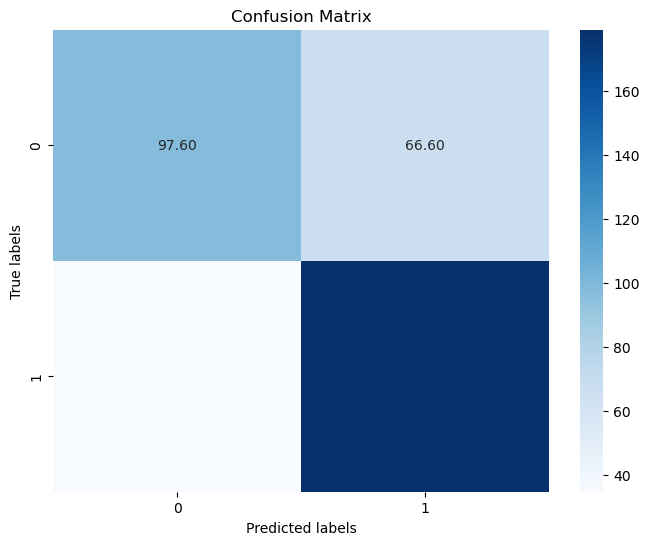

ROC AUC: 0.7140857510815733
PR AUC: 0.7013673350813676


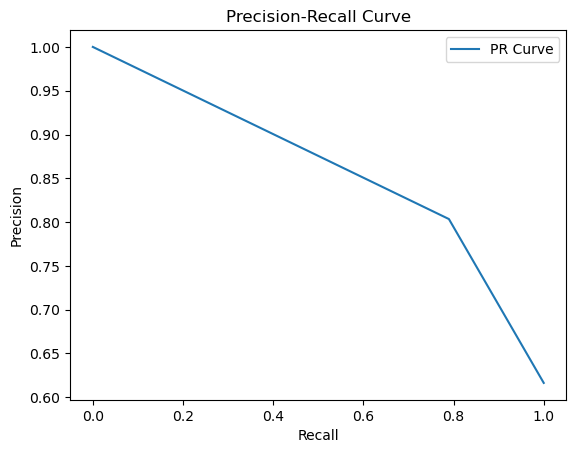

Kappa: 0.4373110942507924


In [59]:
evaluate_model(models, test_results, test_preds)

Average Results Across Folds:
Accuracy: 0.8666051189514506
Precision: 0.8348662494939803
Recall: 0.9528477808289733
F1 Score: 0.8898479680854484
Confusion Matrix: [[495.2 161.6]
 [ 40.2 815.8]]


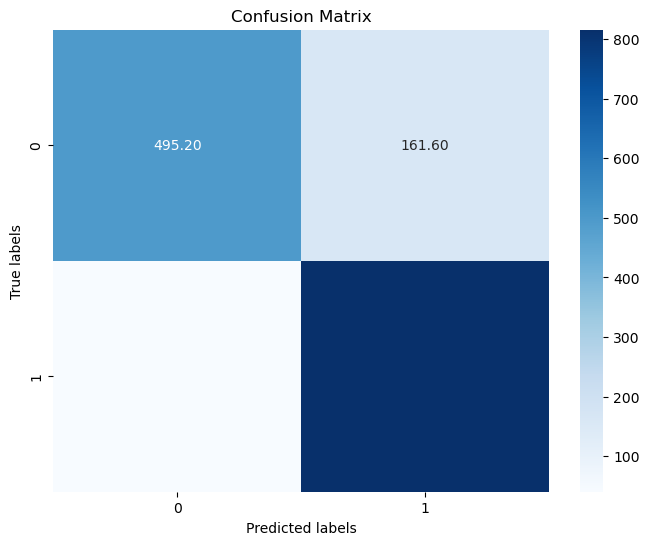

ROC AUC: 0.8533641651165713
PR AUC: 0.8222380169963734


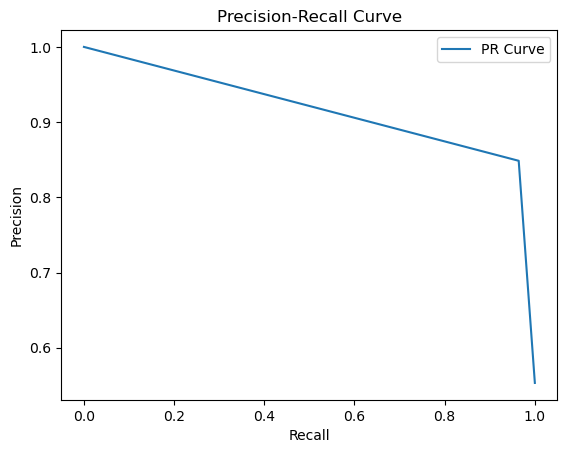

Kappa: 0.722399191028666


In [60]:
evaluate_model(models, train_results, train_preds)

In [61]:
header_names

[array(['_dragon', 'alternative', 'ascii', 'bit', 'boundary', 'iso', 'jp',
        'multipart', 'normal', 'plan'], dtype=object),
 array(['_dragon', 'alternative', 'ascii', 'boundary', 'fans', 'iso', 'jp',
        'multipart', 'normal', 'plan'], dtype=object),
 array(['_dragon', 'alternative', 'ascii', 'bit', 'boundary', 'iso', 'jp',
        'multipart', 'normal', 'plan'], dtype=object),
 array(['alternative', 'ascii', 'bit', 'boundary', 'fans', 'iso', 'jp',
        'multipart', 'normal', 'plan'], dtype=object),
 array(['_dragon', 'alternative', 'ascii', 'bit', 'boundary', 'iso', 'jp',
        'multipart', 'normal', 'plan'], dtype=object)]

In [62]:
body_names

[array(['ascii', 'charset', 'content', 'date', 'dec', 'edu', 'feminist',
        'file', 'gt', 'id', 'know', 'list', 'lt', 'mail', 'message',
        'mime', 'nbsp', 'plain', 'plan', 'px', 'received', 'reply',
        'research', 'sender', 'sep', 'students', 'studies', 'subject',
        'sunbird', 'sundance', 'text', 'thu', 'type', 'university', 'usd',
        'use', 'version', 'webula', 'women', 'work'], dtype=object),
 array(['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
        'aqaqaaaajgypabya', 'ascii', 'cc', 'charset', 'com', 'content',
        'date', 'edu', 'file', 'gt', 'id', 'jul', 'like', 'line', 'list',
        'lt', 'mail', 'message', 'mime', 'nbsp', 'org', 'plain', 'px',
        'received', 'reply', 'sender', 'sep', 'studies', 'subject',
        'sunbird', 'text', 'think', 'type', 'unicode', 'university', 'usd',
        'use', 'version', 'women'], dtype=object),
 array(['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

### 2、采用50%的训练集数据进行训练

In [63]:
header_texts = loadData("./mydata/", "header_texts")
bodies = loadData("./mydata/", "bodies")
is_spam_labels = loadData("./mydata/", "is_spams")
length2 = int(len(header_texts) / 2)
header_texts = header_texts[:length2]
bodies = bodies[:length2]
is_spam_labels = is_spam_labels[:length2]

In [64]:
# 初始化五折交叉验证对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 存储训练的结果
header_names = []
body_names = []
train_preds = []
train_results = []
test_preds = []
test_results = []
models = []
header_number = 10
bodies_number = 40
# 使用五折交叉验证进行数据分割和模型评估
for train_index, test_index in kf.split(header_texts):
    print("开始一轮")
    # 分割数据
    train_header_texts = [header_texts[i] for i in train_index]
    test_header_texts = [header_texts[i] for i in test_index]
    train_bodies = [bodies[i] for i in train_index]
    test_bodies = [bodies[i] for i in test_index]
    train_is_spam_labels = [is_spam_labels[i] for i in train_index]
    test_is_spam_labels = [is_spam_labels[i] for i in test_index]
    # 从训练集中提取特征
    train_name_headers, train_vector_headers = getVector(train_header_texts, train_is_spam_labels, header_number)
    train_name_bodies, train_vector_bodies = getVector(train_bodies, train_is_spam_labels, bodies_number)
    train_vectors = hstack((train_vector_headers, train_vector_bodies))
    header_names.append(train_name_headers)
    body_names.append(train_name_bodies)
    train_results.append(train_is_spam_labels)
    # 训练这个模型
    model = Multinomial(35)
    model.fit(train_vectors, train_is_spam_labels)
    models.append(model)
    train_pred = model.predict(train_vectors)
    train_preds.append(train_pred)
    # 在验证集上提取特征并验证
    test_name_headers, test_vector_headers = getVector(test_header_texts, test_is_spam_labels, header_number)
    test_name_bodies, test_vector_bodies = getVector(test_bodies, test_is_spam_labels, bodies_number)
    test_vectors = hstack((test_vector_headers, test_vector_bodies))
    test_results.append(test_is_spam_labels)
    test_pred = model.predict(test_vectors)
    test_preds.append(test_pred)
    print("结束一轮")

开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮
开始一轮
结束一轮


Average Results Across Folds:
Accuracy: 0.771245250503484
Precision: 0.8970176513874094
Recall: 0.7330327683280725
F1 Score: 0.8051054353580298
Confusion Matrix: [[1131.4  213.8]
 [ 651.4 1785.6]]


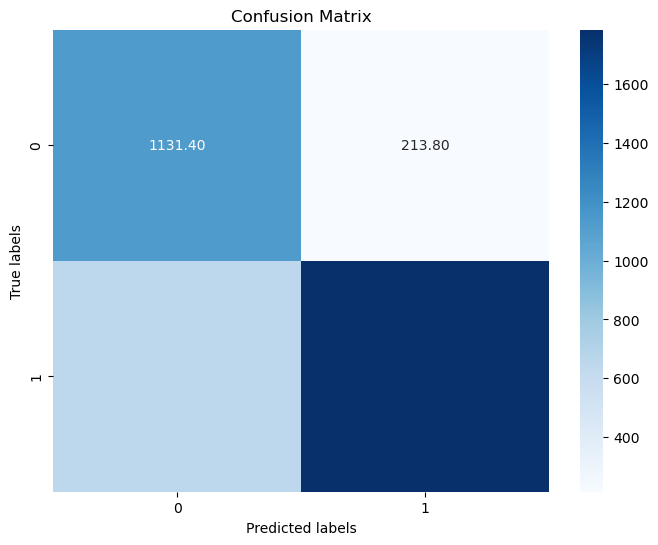

ROC AUC: 0.7861203322069861
PR AUC: 0.8296108474761456


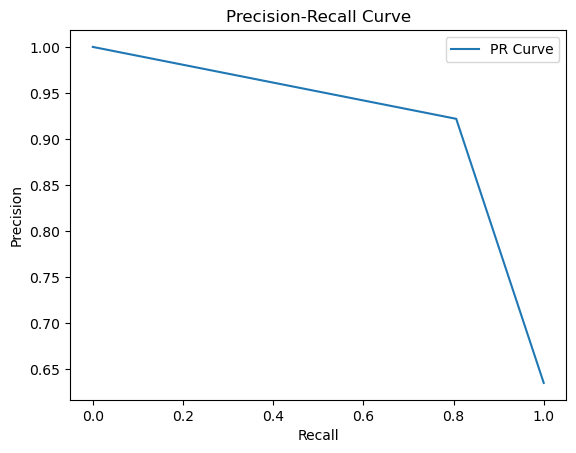

Kappa: 0.5334680213668755


In [65]:
evaluate_model(models, test_results, test_preds)

Average Results Across Folds:
Accuracy: 0.8671012152879909
Precision: 0.9628662539020331
Recall: 0.8255743536077411
F1 Score: 0.8889419347970383
Confusion Matrix: [[5070.4  310.4]
 [1700.2 8047.8]]


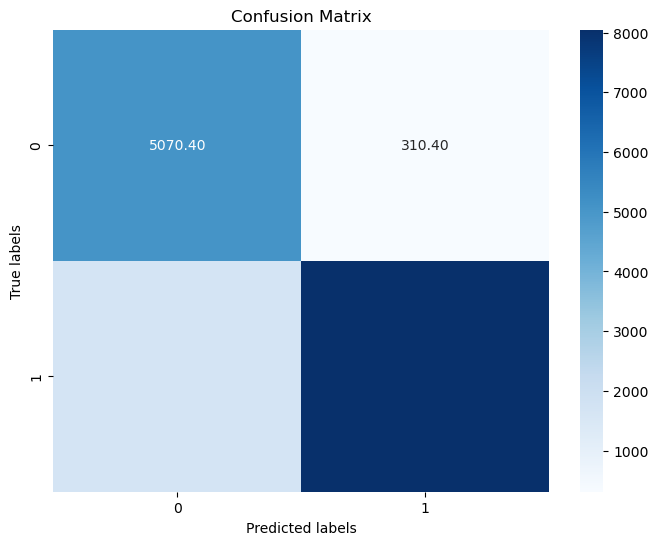

ROC AUC: 0.8839466915285824
PR AUC: 0.9073004889977592


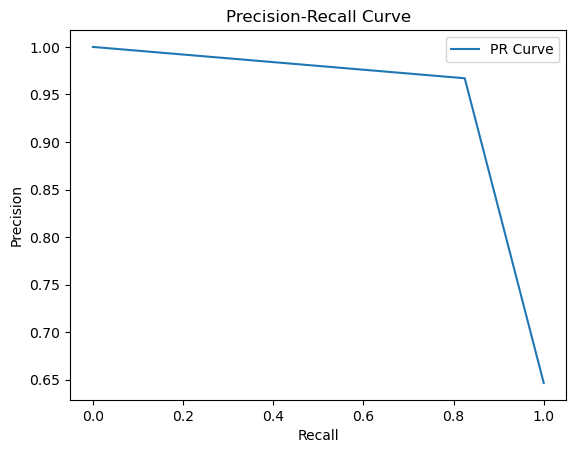

Kappa: 0.7259026834005613


In [66]:
evaluate_model(models, train_results, train_preds)

In [67]:
header_names

[array(['alternative', 'ascii', 'boundary', 'charset', 'handyboard', 'iso',
        'jp', 'multipart', 'plain', 'text'], dtype=object),
 array(['alternative', 'ascii', 'boundary', 'charset', 'handyboard', 'iso',
        'jp', 'multipart', 'plain', 'text'], dtype=object),
 array(['alternative', 'ascii', 'boundary', 'charset', 'handyboard', 'iso',
        'jp', 'multipart', 'plain', 'text'], dtype=object),
 array(['alternative', 'ascii', 'boundary', 'charset', 'handyboard', 'iso',
        'jp', 'multipart', 'plain', 'text'], dtype=object),
 array(['alternative', 'ascii', 'boundary', 'charset', 'handyboard', 'iso',
        'jp', 'multipart', 'plain', 'text'], dtype=object)]

In [68]:
body_names

[array(['adobe', 'board', 'border', 'com', 'crust', 'edu', 'file', 'font',
        'handy', 'handyboard', 'hb', 'ic', 'id', 'know', 'line', 'list',
        'majordomo', 'message', 'motor', 'nbsp', 'nil', 'padding', 'plain',
        'price', 'problem', 'product_table', 'px', 'received', 'send',
        'subject', 'subscribe', 'thanks', 'unicode', 'university', 'use',
        'using', 'version', 'vims', 'weight', 'wrote'], dtype=object),
 array(['board', 'border', 'crust', 'date', 'edu', 'file', 'font', 'handy',
        'handyboard', 'hb', 'ic', 'id', 'know', 'list', 'majordomo',
        'message', 'motor', 'nbsp', 'nil', 'padding', 'plain', 'price',
        'product_table', 'px', 'received', 'send', 'studies', 'subject',
        'subscribe', 'thanks', 'unicode', 'university', 'usd', 'use',
        'using', 'version', 'vims', 'weight', 'women', 'wrote'],
       dtype=object),
 array(['board', 'border', 'code', 'crust', 'date', 'edu', 'file', 'font',
        'handy', 'handyboard', 'hb', '